## Импорт библиотек

In [ ]:
#импорт библиотек
import glob
import os
import pandas as pd
import numpy as np
import json
import docx
from bs4 import BeautifulSoup as bs
import requests
from tqdm.auto import tqdm, trange
from pymystem3 import Mystem
from nltk.stem.snowball import SnowballStemmer 
from nltk.tokenize import word_tokenize
from nltk.stem import *
from nltk.corpus import stopwords
import string
import re
import pyLDAvis.sklearn
import pyLDAvis
import pyLDAvis.lda_model
import pymorphy2

## 1.1 Парсинг данных

Получим список компаний из docx документа

In [ ]:
docx = docx.Document('Condidates.docx')
parag = docx.paragraphs

In [ ]:
company_docx = []
for i in parag:
    company_docx.append(i.text)
company_docx

В списке присутсвуют пустые строки, которые надо удалить

In [ ]:
company_docx = list(filter(None, company_docx))
company_docx

### Парсинг Json файла

Получаем список файлов, которые находятся в папке Data

In [ ]:
list_json = glob.glob("Data/*.json")

Парсинг файлов

In [ ]:
companies_json = {'name':[], 'raiting':[], 'date':[], "text":[], 'about': [], 'industries':[]}
for json_text in list_json:
    with open(json_text, "r", encoding='utf-8') as f: #Чтение файлов
        text = json.load(f)
    for i in text['refs']: # Получение данных из полей "refs", в котором находится информация о содержании текста, и его даты
        name = f.name[5:-5]

        if text['info'] != None: # Получение данных из полей "info", в котором находится информация о содержании текста, и его даты
            companies_json['industries'].append(text["info"]["industries"])
            companies_json['about'].append(text["info"]["about"])
            companies_json['raiting'].append(text["info"]["rate"])
        else:
            companies_json['industries'].append(np.nan)
            companies_json['about'].append(np.nan)
            companies_json['raiting'].append(np.nan)

        companies_json['name'].append(name) # Получение названии компании через название файла
        if i != None:
            companies_json['text'].append(i)

            date = i[1]
            date1 = date['day'] + " " + date["month"] + " " + date["time"]
            companies_json['date'].append(date1)
        else:
            companies_json['text'].append(np.nan)
            companies_json['date'].append(np.nan)

In [ ]:
df = pd.DataFrame.from_dict(data=companies_json, orient="index")
df = df.transpose()
df

### Заполнение данных об статьях комампний, которые указаны в docx файле

Вывод уникальных названий компаний в новый список.

In [ ]:
import numpy as np
uniq_comp = np.unique(companies_json['name'])
print(uniq_comp)

Вывод названий компаний, которые отсутсвуют в Json списке, в новый список

In [ ]:
not_in_json = []
for comp in company_docx:
    if comp not in uniq_comp:
        not_in_json.append(comp)
not_in_json

На основе датасета с данными из Json добавляем информацию о компаниях, которые есть в спике docx документа, но нет в этом датасете. Если такие существуют, то находим информацию и компании на сайте Хабр и получаем текст и дату последних 10 статьей

In [ ]:
df = pd.DataFrame.from_dict(data=companies_json, orient="index")
df = df.transpose()
df

Сохранение данных в csv формате

In [ ]:
# Запись файла
FILE_NAME = "habr.csv"
df = pd.DataFrame.from_dict(data=companies_json, orient="index")
df = df.transpose()
df.columns=['name', 'raiting', 'date', "text", 'about', 'industries']
df.to_csv(FILE_NAME, index=False)

In [ ]:
# Чтение файла
df = pd.read_csv('habr.csv')
df.info()

__Вывод__: получили данные статьей из Json файла и информацию об компаниях и их статьях с сайта Habr. Также заполнили недостоющую информацию о компаниях в Json файле, у которых остутсвовала информация. Сформировали все данные с единый датасет

## 1.2 Формирование структуры набора данных

Проверка на пустые значения

In [ ]:
df.isnull().sum()

Определим нужные атрибуты, для номинации премии Рунета.
Название для определения победителя, текст определения сферы в номинации и рейтинг. Остальные артибуты удалим

In [ ]:
df = df.drop(['about'], axis=1)
df = df.drop(['date'], axis=1)
df = df.drop(['industries'], axis=1)

Удалим статьи, которые содержат пустые значения

In [ ]:
df = df.dropna()

In [ ]:
df

__Вывод:__ определили нужные атрибуты, которые будем использовать для последующей обработки. Удалили статьи, у которых были пустые поля.

### 1.3 Предварительная обработка текстовых данных 

Создадим функции для удаления лишних слов и символов

In [ ]:
import string
from pymystem3 import Mystem
from tqdm.auto import tqdm, trange
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer as snow 

def remove_punctuation(text): #Функция удаления знаков препинания
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])
def remove_numbers(text): #Функция удаления чисел
    return ''.join([i if not i.isdigit() else ' ' for i in text])
def remove_multiple_spaces(text): #Функция удаления пробелов
    return re.sub(r'\s+', ' ', text, flags=re.I)

In [ ]:
prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower()))) for text in tqdm(df['text'])]

In [ ]:
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian") #создание списка стоп-слов
russian_stopwords.extend(['…', '«', '»', '...', 'т.д.', 'т', 'д', 'это']) #Дополнение стоп-слов

### Токенизация

In [ ]:
sw_texts_list = [] #создание списка текста с удаленными стоп словами
for text in tqdm(prep_text):
    tokens = word_tokenize(text)    
    tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
    text = " ".join(tokens)
    sw_texts_list.append(text)

df['text_sw'] = sw_texts_list

### Стемминг

In [ ]:
stemmer = snow("russian") 
stemmed_texts_list = [] #создание списка стемминга слов
for text in tqdm(df["text_sw"]):
    tokens = word_tokenize(text)    
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in russian_stopwords]
    text = " ".join(stemmed_tokens)
    stemmed_texts_list.append(text)

df['text_stem'] = stemmed_texts_list

### Лемитизация

In [ ]:
from pymystem3 import Mystem
from tqdm.auto import tqdm, trange
mystem = Mystem() 
lemm_texts_list = [] # создание и заполенение списка с текстом статей, где словам присвоили начальную форму.
for text in tqdm(df["text_sw"]):
    try:
        text_lem = mystem.lemmatize(text)
        tokens = [token for token in text_lem if token != ' ' and token not in russian_stopwords]
        text = " ".join(tokens)
        lemm_texts_list.append(text)
    except Exception as e:
        print(e)
    
df['text_lemm'] = lemm_texts_list

In [ ]:
df['text_sw'].drop
df['text_stem'].drop

In [ ]:
df

### Выделение частей речи

Процесс преобразования предложения в формы, то есть в список слов или кортежей (каждый кортеж имеет вид [слово, часть речи]).

In [ ]:
morph = pymorphy2.MorphAnalyzer(lang='ru')

__pymorphy2__ умеет разбирать не только словарные слова; для несловарных слов автоматически задействуется предсказатель.

In [ ]:
ps_text_list = []
for text in tqdm(df['text_lemm']):
    try:
        words = word_tokenize(text)
        text_list = []
        for i in range(len(words)):
            p = morph.parse(words[i])[0]
            text_list.append("(" + words[i] + ", " + str(p.tag.POS) + ")")
        ps_text_list.append(text_list)
    except Exception as e:
        print(e)
df['text_ps'] = ps_text_list

In [ ]:
df.head()

In [ ]:
df.to_csv('habr_f.csv', index=False)

## 1.4 Поиск n-грамм. Векторизация текстов

__Мешок слов__ - решает проблему размерности по одной оси. Количество строк определяется количеством документов. Однако, этот метод не учитывает важность того или иного токена, ведь одно слово может повторятся по несколько раз.

__TF-IDF__ - это способ векторизации текста, отражающий важность слова в документе, а не только частоту его появления.

__Word Embeddings__ - векторное представление слов. Векторы можно складывать, вычитать, сравнивать.

In [ ]:
df.isnull().sum()

In [ ]:
# Чтение файла
df = pd.read_csv('habr_f.csv')
df.info()

In [ ]:
df

### Векторизация мешок слов

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorizer = CountVectorizer(analyzer='word', stop_words=russian_stopwords, ngram_range=(1, 3), min_df=2)
count_matrix = vectorizer.fit_transform(df['text_lemm'])

In [ ]:
count_matrix.shape

In [ ]:
vectorizer.get_feature_names_out()[:50]

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
RAND = 10
lda_model = LatentDirichletAllocation(n_components=11)

In [ ]:
lda_model.fit(count_matrix)

### Векторизация TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000,
                                 min_df=0.01, stop_words=russian_stopwords,
                                 ngram_range=(1,3))

In [ ]:
%%time
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text_lemm'])

In [ ]:
tfidf_matrix.shape

In [ ]:
tfidf_vectorizer.get_feature_names_out()[:100]

## 1.4.4 Векторизация Word Embeddings

In [ ]:
import nltk

In [ ]:
from gensim.models import Word2Vec

In [ ]:
Bigger_list=[]
for i in df['text_lemm']:
     li = list(word_tokenize(i))
     Bigger_list.append(li)
Model= Word2Vec(Bigger_list,min_count=1,vector_size=300,workers=4)

In [ ]:
Model.wv.key_to_index

In [ ]:
df.head()

### Добавление ключевых слов, биграмм и триграмм

In [ ]:
for i in range(len(df)):
    tfidf_vectorizer = TfidfVectorizer(stop_words=russian_stopwords, ngram_range=(1,1))
    tfidf_matrix= tfidf_vectorizer.fit_transform([df.loc[i, 'text_lemm']]).toarray()
    df.loc[i, 'keyword'] = str(dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_matrix[0])))
    
    tfidf_vectorizer = TfidfVectorizer(stop_words=russian_stopwords, ngram_range=(2,2))
    tfidf_matrix= tfidf_vectorizer.fit_transform([df.loc[i, 'text_lemm']]).toarray()
    df.loc[i, 'bigrams'] = str(dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_matrix[0])))
    
    tfidf_vectorizer = TfidfVectorizer(stop_words=russian_stopwords, ngram_range=(3,3))
    tfidf_matrix= tfidf_vectorizer.fit_transform([df.loc[i, 'text_lemm']]).toarray()
    df.loc[i, 'trigrams'] = str(dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_matrix[0])))

In [ ]:
df.head()

In [ ]:
df.to_csv('dataset.csv', index=False )

## 1.5 Разведочный анализ

In [ ]:
with open('Target.json', "r",encoding="utf-8") as my_file: #Открытие json файла
    target_json = my_file.read() #чтение

In [ ]:
import json

In [ ]:
targets = json.loads(target_json) #загрузка

In [ ]:
namecomp = []
nominat = []
for i in range(len(targets['list'])):
    namecomp.append(targets['list'][i]['Сompany'])
    nominat.append(targets['list'][i]['Nominations'])

In [ ]:
targets = pd.DataFrame()

In [ ]:
targets['namecompany'] = namecomp
targets['nomination'] = nominat

In [ ]:
targets

In [ ]:
targetscomp = []
for i in range(len(df['name'])):
        k = 0
        for j in range(len(targets['namecompany'])):
            if(df['name'][i].lower().strip() == targets['namecompany'][j].lower().strip()):
                targetscomp.append(targets['nomination'][j])
            else:
                k = k + 1
        if(k == len(targets['namecompany'])):
            targetscomp.append('Нет номинации')   

In [ ]:
len(targetscomp)

In [ ]:
df['target'] = targetscomp

In [ ]:
df.to_csv('dataset.csv', index=False)

In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df['target2']= label_encoder.fit_transform(df['target'])

In [ ]:
sns_plot = sns.distplot(df['target2'])
fig = sns_plot.get_figure()

In [ ]:
sns_plot = sns.boxplot(df['target2'])
fig = sns_plot.get_figure()

Ящик с усами скошен в лево, 3,4,5 кластеры малочисленно

In [ ]:

import matplotlib.pyplot as plt

data = articles_full["code"]

#список цветов
colors = ["red", "blue", "green", "yellow", "orange", "purple", "pink", "brown", "gray", "cyan"]


data.value_counts().plot(kind='pie', colors=colors)

plt.title('Распределение категориального признака')


plt.show()

In [ ]:
# Пример категориальных данных
data = articles_full["code"]

# Построение круговой диаграммы
data.value_counts().plot(kind='pie')

# Настройка заголовка
plt.title('Распределение категориального признака')

# Отображение графика
plt.show()

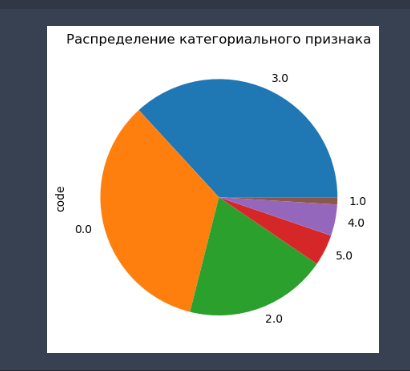

In [ ]:
df = pd.read_csv('dataset.csv')

Визуальный анализ статистики публикаций


In [ ]:
sns.set(rc={'figure.figsize':(40,10)})
sns.countplot(df, x="namecompany")

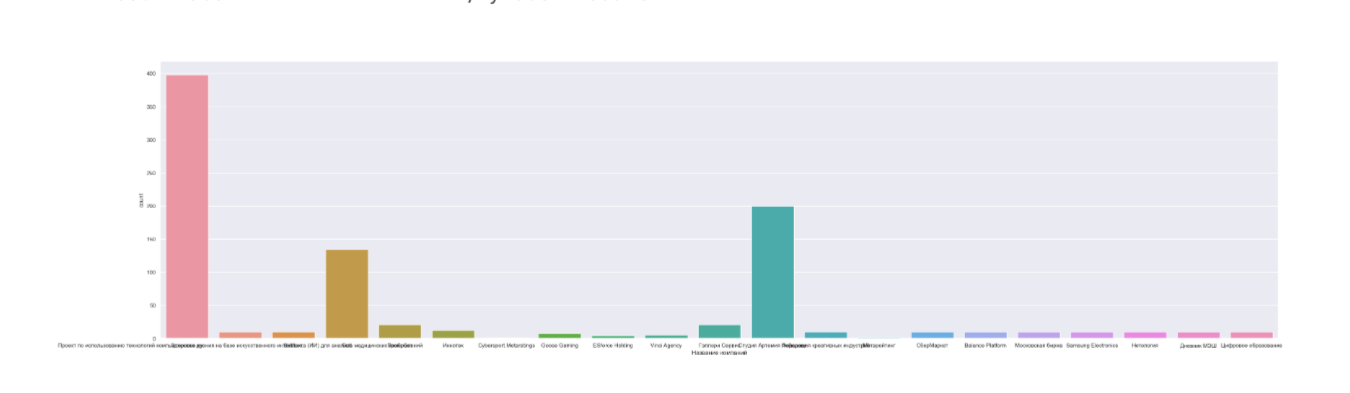